# Começando a pensar no projeto


## Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de teste de produtos. Nesse projeto, espera-se a criação de valor que **discrimine ao máximo** os **produtos com falhas** dos **produto sem falhas**. 

Para cada product_code, você recebe vários atributos de produto (fixados para o código), bem como vários valores de medição para cada produto individual, representando vários métodos de teste de laboratório. Cada produto é usado em um experimento simulado de ambiente do mundo real e absorve uma certa quantidade de fluido (carregamento) para ver se falha ou não.

Sua tarefa é usar os dados para prever falhas de novos códigos de produtos individuais com seus resultados de testes de laboratório individuais.

Para isso, foi disponibilizada uma base de dados com milhares de casos de **testes do passado** com diversas características dos produtos. 

Entrega: um modelo com a **melhor performance** possível.

Métrica de performance (inicialmente proposta): **ROC-AUC** (mas isso é flexível, conforme detalhado mais abaixo!)

## Base de Dados

Serão utilizadas bases de dados com **informações de diversos produtos**. 

O conjunto de dados está dividido em **treino e teste**, todos no formato csv. 

Toda a modelagem, validação e avaliação deve ser feita em cima do conjunto de **treino**, que contém o target (arquivo: `train_data.csv`)

## INICIANDO O PROJETO

**Carregando as bibliotecas**

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# ANÁLISE E EXPLORAÇÃO DOS DADOS

In [33]:
# Ler datasets
train_data_read = pd.read_csv('train_data.csv')
test_data_read = pd.read_csv('test_data.csv')

In [34]:
# Avaliar a quantidade de linhas dos dados de treino
train_data_read.shape

(21256, 27)

In [35]:
# Avaliar a quantidade de linhas dos dados de teste
test_data_read.shape

(5314, 27)

In [36]:
# Verificar o quão desbalanceado está o target
train_data_read['failure'].value_counts()

0    16737
1     4519
Name: failure, dtype: int64

Como é notado acima, o target está muita desbalanceado. Dessa forma é necessário aplicar algumas técnicas de balanceamento e comparar os resultados.

In [37]:
# Analisando o dataset de treino
train_data_read.head()

,Unnamed: 0,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,2596,2596,A,94.34,material_7,material_8,9,5,6,2,...,10.625,NaN,15.828,12.402,13.289,15.886,15.990,15.352,803.056,1
1,23021,23021,E,117.02,material_7,material_6,6,9,11,10,...,10.941,13.620,17.654,11.603,14.949,18.139,13.940,NaN,719.968,0
2,10202,10202,B,256.42,material_5,material_5,8,8,5,10,...,10.620,16.771,17.423,NaN,16.413,14.752,16.220,16.671,661.213,1
3,19048,19048,D,87.76,material_7,material_5,6,6,5,13,...,10.387,18.028,19.016,11.727,16.378,17.244,15.472,14.017,536.760,0
4,14789,14789,C,97.84,material_7,material_8,5,8,17,6,...,13.372,15.236,19.875,9.911,16.082,18.070,15.504,15.130,535.931,1


Percebe-se a principio que as colunas 'Unnamed: 0' e id tem os mesmo valores. Dessa forma é necessário uma análise mais minuciosa para confirmar tal hipótese.

In [38]:
# Verifcar quantidade de valores da coluna 'Unnamed: 0'
len(train_data_read['Unnamed: 0'].unique().tolist())

21256

In [39]:
# Verifcar quantidade de valores da coluna id
len(train_data_read['id'].unique().tolist())

21256

In [40]:
# Comparar os valores das duas colunas
comparation_id_column = pd.DataFrame(train_data_read['Unnamed: 0'] == train_data_read['id'], columns=['Result'])

In [41]:
# Busca por registros onde a comparação foi falsa
comparation_id_column.query('Result == False')

,Result


In [42]:
# Como esperado as duas primeiras colunas são iguais e são colunas de indexação. 
# Sendo assim ambas serão excluídas.
train_data_read.drop(axis=1, columns=['Unnamed: 0', 'id'], inplace=True)
test_data_read.drop(axis=1, columns=['Unnamed: 0', 'id'], inplace=True)

Nota-se também que algumas colunas são categóricas, dessa forma é necessário trata-lás previamente. Mais a frente será técnicas para lidar com dados categóricos. 

Outra análise importante é sobre a quantidade de valores nulos. Esse caso também requer algum tipo de tratamento para melhorar a qualidade dos dados sem a necessidade de excluir todo o registro.

Aqui observa-se que existem algumas colunas com dados nulos.
Porém nem todas as features serão relevantes para o modelo.
Para otimizar o volume das features utilizadas no treinamento será avaliado o valor das suas correlações logo abaixo

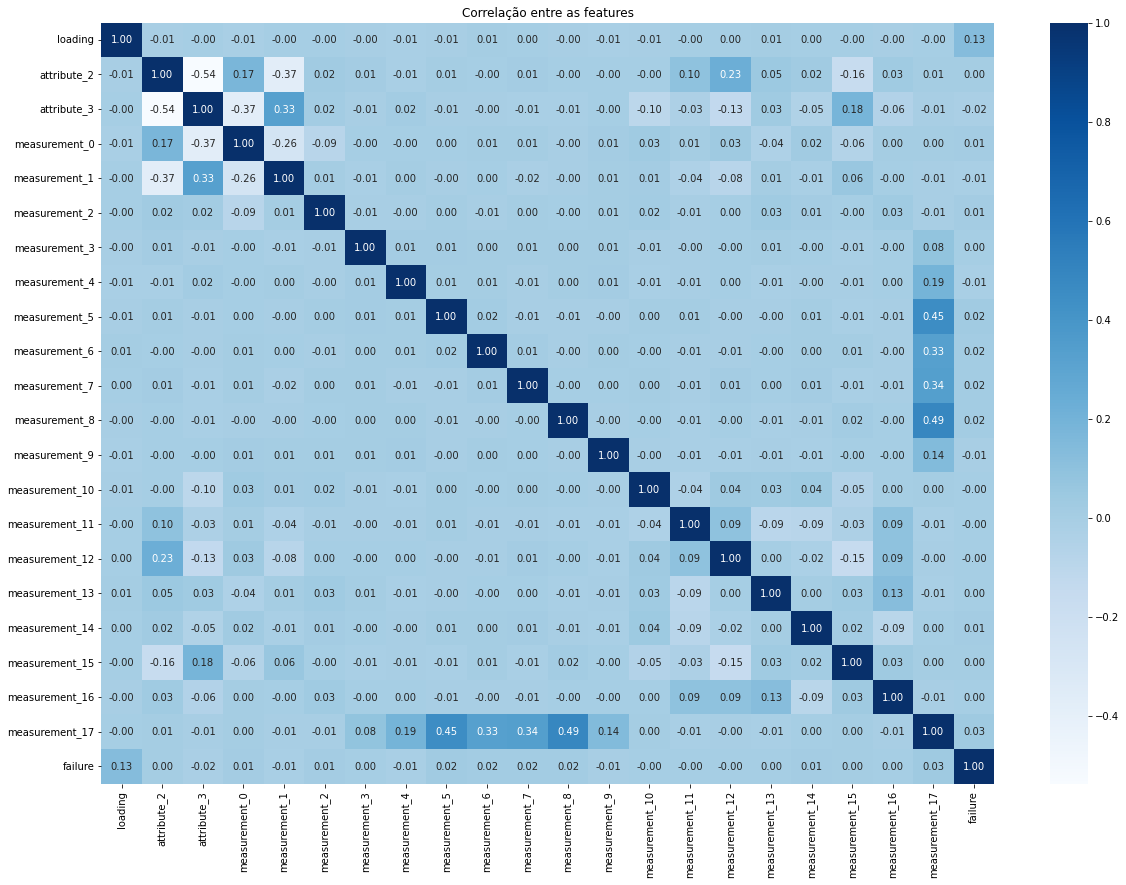

In [43]:
# Visualização das correlações
plt.figure(figsize=(20, 14))
sns.heatmap(train_data_read.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre as features')
plt.show()

Devido a baixa correlação que grande parte das features apresentam foram mantidas apenas aquelas com correlação maior que 0.3

In [44]:
# Colunas selecionadas para serem excluidas devido a baixa correlação
drop_columns = [
     'loading'
    ,'measurement_3'
    ,'measurement_4'
    ,'measurement_5'
    ,'measurement_6'
    ,'measurement_7'
    ,'measurement_8'
    ,'measurement_9'
    ,'measurement_13'
]

In [45]:
# DataFrame de treino resultante após exclusão das features com baixa correlação
train_data_without_low_correlation_features = train_data_read.drop(axis=1, columns=drop_columns, inplace=False)

In [46]:
# DataFrame de teste resultante após exclusão das features com baixa correlação
test_data_without_low_correlation_features = test_data_read.drop(axis=1, columns=drop_columns, inplace=False)

Escolhida as colunas que serão relevantes para o modelo, inicia-se o tratamento com os dados já separados. Como foi fornecido um arquivo separado com os dados de teste não será aplicado o train_test_split nesse caso.

In [47]:
# Setando as features de treino
X_train = train_data_without_low_correlation_features.drop(columns=['failure'])

# Setando o target de treino
y_train = train_data_without_low_correlation_features['failure']

In [48]:
# Setando as features de teste
X_test = test_data_without_low_correlation_features.drop(columns=['failure'])

# Setando o target de teste
y_test = test_data_without_low_correlation_features['failure']

# Preprocessamento de dados -> FEATURE ENGINEERING

In [49]:
# Primeramente é necessário separar as colunas categóricas das numéricas.
# Uma das formas utilizadas é aplicando a filtragem pelo tipo da coluna com o método select_dtypes

# Colunas categoricas
categorical_columns = list(X_train.select_dtypes('object').columns)

# Colunas numéricas
numerical_columns = list(X_train.select_dtypes('number').columns)

In [50]:
# Definida o conjunto de colunas pelo tipo, o próximo passo é definir as tratativas do pipeline.
# Nesse caso os valores nulos serão substituídos pela string # e posteriormente os dados serão transformados
#em valores numéricos utilizando a técnica de OneHotEncoder
categorical_pipeline = Pipeline([ 
     ('impute', SimpleImputer(strategy='constant', fill_value='#')),
     ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
])

In [51]:
# Pipeline para tratamento numérico. Nesse caso foi escolhido a estratégia de preenchimento pela média
#e MinMaxScaler como método de escalonamento.
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler()) 
])

In [52]:
# Como será aplicado tratamento separado para as colunas do tipo categórica e numérica
#utiliza-se a técnica de ColumnTransformer, que permite criar um pipeline com tratamentos
#distintos por conjunto de colunas.
column_transformer_pipeline = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_columns),
    ('num', numeric_pipeline, numerical_columns)
])

In [53]:
# Ajuste dos dados pré transformação
column_transformer_pipeline.fit(X_train, y_train)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(fill_value='#',
                                                                strategy='constant')),
                                                 ('encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['product_code', 'attribute_0',
                                  'attribute_1']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['attribute_2', 'attribute_3', 'measurement_0',
                                  'measurement_1', 'measurement_2',
                                  'measurement_10', 'measurement_11',
                                  'measurement_12', 'measurement_14',
                                  'measurement_15', 'measurement_16',
                                  'measurement_17'])])

In [54]:
# Para visualizar maior quantidade de linhas
pd.options.display.max_rows = 100

In [55]:
# Para visualisar os dados após o tratamento é necessário transformá-los novamente em um DataFrame.
# Como o método do OneHotEncoder cria novas colunas é preciso antes obter o nome das novas colunas.

# Lista com o nome das colunas categóricas que foram utilizadas
categorical_transform_names = column_transformer_pipeline.named_transformers_['cat']['encode'].get_feature_names_out(categorical_columns)

# Lista com o nome de todas as colunas
columns_transform_name = np.append(categorical_transform_names, numerical_columns)

# Conjunto de treino após a transformação
X_train_reload_df = pd.DataFrame(column_transformer_pipeline.transform(X_train), columns=columns_transform_name)

In [56]:
X_train_reload_df.head()

,product_code_B,product_code_C,product_code_D,product_code_E,attribute_0_material_7,attribute_1_material_6,attribute_1_material_8,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_10,measurement_11,measurement_12,measurement_14,measurement_15,measurement_16,measurement_17
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.00,0.00,0.206897,0.068966,0.125000,0.000000,0.617317,0.702146,0.724066,0.739388,0.637171,0.611715
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.25,1.00,0.379310,0.344828,0.291667,0.605899,0.688534,0.656910,0.826755,0.644594,0.000000,0.548424
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.75,0.172414,0.344828,0.291667,0.746074,0.679524,0.000000,0.672379,0.750023,0.691915,0.503669
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.25,0.25,0.172414,0.448276,0.416667,0.801993,0.741654,0.663930,0.785962,0.715435,0.581763,0.408868
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.00,0.75,0.586207,0.206897,0.125000,0.677788,0.775156,0.561116,0.823610,0.716915,0.627957,0.408237


In [57]:
# Transformado os dados cria-se o pipeline de treinamento
train_pipeline = Pipeline([
    ('transformer_pipe', column_transformer_pipeline),
    ('balancear', RandomOverSampler(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [58]:
# Instanciar um estimador
descicion_tree_estimator = DecisionTreeClassifier(random_state=42)

#Instanciar um método de feature selection
recursive_feature_elimination = RFE(estimator=DecisionTreeClassifier(random_state=42))

# Criar um pipeline
pipe = Pipeline([
    ('transformer_pipe', column_transformer_pipeline),
    ('balanced_method', RandomOverSampler(random_state=42)),
    ("rfe", recursive_feature_elimination), 
    ('scaler', MinMaxScaler()),
    ("dt", descicion_tree_estimator)])

# Definir os parâmetros do grid search
param_grid_dt = {"rfe__n_features_to_select" : range(1, X_train.shape[1]+1),
                 "dt__criterion" : ['gini', 'entropy', 'log_loss']}

# Instanciar os samples de treinamento
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instanciar GridSearchCV
grid_dt = GridSearchCV(pipe, 
                       param_grid_dt, 
                       scoring="roc_auc", 
                       cv=splitter, 
                       n_jobs=-1) 

# Fit do modelo
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transformer_pipe',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(fill_value='#',
                                                                                                        strategy='constant')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['product_code',
                                                                          'attribute_0',
                                                                          'attrib...
                                                                          'measurement_16',
                                                                          'measurement_17'])])),
                                       ('balanced_method',
                                        RandomOverSampler(random_state=42)),
                                       ('rfe',
                                        RFE(estimator=DecisionTreeClassifier(random_state=42))),
                                       ('scaler', MinMaxScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini', 'entropy', 'log_loss'],
                         'rfe__n_features_to_select': range(1, 16)},
             scoring='roc_auc')

In [59]:
# Melhores parâmetros encontrados
grid_dt.best_params_

{'dt__criterion': 'gini', 'rfe__n_features_to_select': 9}

In [60]:
#Melhor escore 
grid_dt.best_score_

0.5081404557622177

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      4184
           1       0.21      0.22      0.22      1130

    accuracy                           0.66      5314
   macro avg       0.50      0.50      0.50      5314
weighted avg       0.67      0.66      0.66      5314



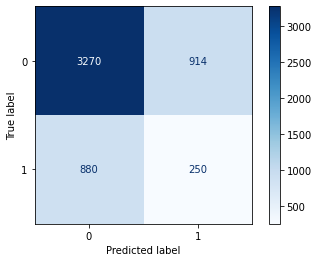

In [61]:
# Métricas de classificação
y_pred_grid = grid_dt.predict(X_test)

print(classification_report(y_test, y_pred_grid))

cm_rfe = confusion_matrix(y_test, y_pred_grid)

ConfusionMatrixDisplay(cm_rfe).plot(cmap='Blues')

In [63]:
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)
    y_probs_train = estimator.predict_proba(X_train)[:, 1]

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))
    
    disp = RocCurveDisplay.from_predictions(y_train, y_probs_train)
    disp.ax_.set_title(f"AUC: {roc_auc_score(y_train, y_probs_train):.3f}", fontsize=16)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, ls=":", color="black")
    plt.show()

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)
    y_probs_test = estimator.predict_proba(X_test)[:, 1]

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))
    
    disp = RocCurveDisplay.from_predictions(y_test, y_probs_test)
    disp.ax_.set_title(f"AUC: {roc_auc_score(y_test, y_probs_test):.3f}", fontsize=16)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, ls=":", color="black")
    plt.show()


Métricas de avaliação de treino:


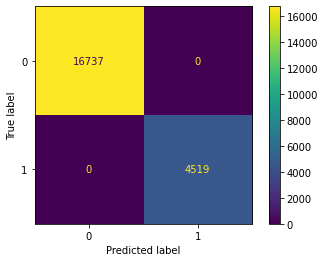

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16737
           1       1.00      1.00      1.00      4519

    accuracy                           1.00     21256
   macro avg       1.00      1.00      1.00     21256
weighted avg       1.00      1.00      1.00     21256



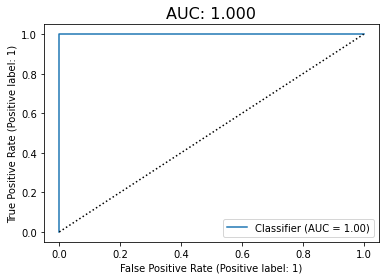


Métricas de avaliação de teste:


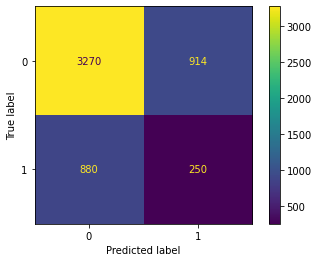

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      4184
           1       0.21      0.22      0.22      1130

    accuracy                           0.66      5314
   macro avg       0.50      0.50      0.50      5314
weighted avg       0.67      0.66      0.66      5314



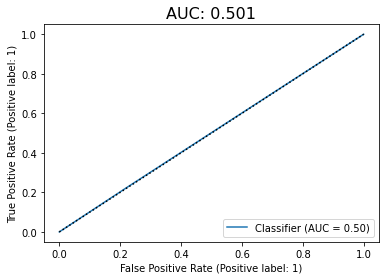

In [64]:
# Avaliação da curva ROC
metricas_classificacao(grid_dt, X_train, X_test, y_train, y_test)

Como pode ser analisado acima, o modelo teve 100% de acerto para o treinamento, porém apenas 66% de acurácia para o teste.
Além do estimador DecisionTreeClassifier, também foram avaliados RandomForestClassifier e LogisticRegression, porém ambos apresentaram resultados inferiores.

Além disso também foi feito testes com diferentes estratégias de preenchimentos no balanceamento, no entanto não resultaram em diferenças significativas com outras estratégias de balanceamento.